In [1]:
import pandas as pd, numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
import warnings
warnings.filterwarnings("ignore")

In [6]:
#Read the dataset and apply SMOTE for class imbalanace

df = pd.read_csv('Data\creditcard.csv')
df.drop(columns=['Time', 'Amount'], inplace=True)

# Oversampling the inferior class with more than 10% 
# of the superior class size. With enough random sample
#size we are guaranteed that we keep as good an approximation
# as of the original distribution.

c = df[df.Class==0].sample(100*(df.Class==1).sum())
f = df[df.Class==1]
final_df = shuffle(pd.concat([c,f], ignore_index=True))
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1]
oversample = SMOTE()
data, labels = oversample.fit_resample(data, labels)

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=4)
print(f'Number of samples for class 0 : {(Y_train==0).sum()} \nNumber of samples for class 1: {(Y_train==1).sum()}'\
      f'\nAs we can see the sizes are almost identical.\n')

#################################################################################################
# Split train dataset into labeled and unlabeled
#################################################################################################

X_train_lab, X_train_unlab, Y_train_lab, Y_train_unlab= train_test_split(X_train.to_numpy(), 
                                                                         Y_train.to_numpy(),
                                                                         random_state=np.random.RandomState(5))

#Training of the labeled data and testing results

label_model = LogisticRegression(random_state=4).fit(X_train_lab, Y_train_lab)
predictions1 = label_model.predict(X_test)
score1 = metrics.accuracy_score(Y_test, predictions1)
f1_1 = metrics.accuracy_score(Y_test, predictions1)
print(f'Task_3 accuracy: {score1} \t f1: {f1_1}.')

Number of samples for class 0 : 39381 
Number of samples for class 1: 39339
As we can see the sizes are almost identical.

Task_3 accuracy: 0.9454268292682927 	 f1: 0.9454268292682927.


Most of distribution of each feature are almost identical if you check them. Few of them have some differences.


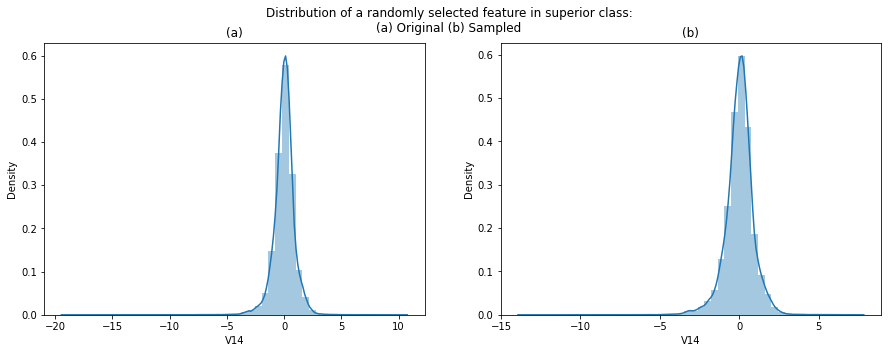

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution of a randomly selected feature in superior class:\n(a) Original (b) Sampled')
sns.distplot(df.V14, ax=axes[0]).set_title('(a)') 
sns.distplot(c.V14, ax=axes[1]).set_title('(b)') 
print(f'Most of distribution of each feature are almost identical if you check them. Few of them have some differences.')

In [ ]:
# create "no label" for unlabeled data (-1==unlabeled)

unlabeled = np.ones(len(Y_train_unlab))*(-1)

# recombine training dataset labels

mixed_data = np.concatenate((X_train_lab, X_train_unlab))
mixed_labels = np.concatenate((Y_train_lab, unlabeled))

# define and train model

unlabeled_model = LabelPropagation('knn')
unlabeled_model.fit(mixed_data, mixed_labels)
predictions2 = label_model.predict(X_test.to_numpy())
score2 = metrics.accuracy_score(Y_test.to_numpy(), predictions2)
f1_2 = metrics.f1_score(Y_test.to_numpy(), predictions2)

print(f'Task_3 accuracy: {score2} \t f1: {f1_2}.')

In [ ]:
# Take the predicted labels and train on them
# the logistic regression model and test on the 
# original test sample

given_labels = unlabeled_model.transduction_
label_model = LogisticRegression(random_state=4)
label_model.fit(mixed_data, given_labels)
predictions3 = label_model.predict(X_test.to_numpy())
score3 = metrics.accuracy_score(Y_test.to_numpy(), predictions3)
ff1_3 = metrics.f1_score(Y_test.to_numpy(), predictions3)

print(f'Task_4 accuracy: {score3} \t f1: {ff1_3}.')